In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve

labeled samples: 1250


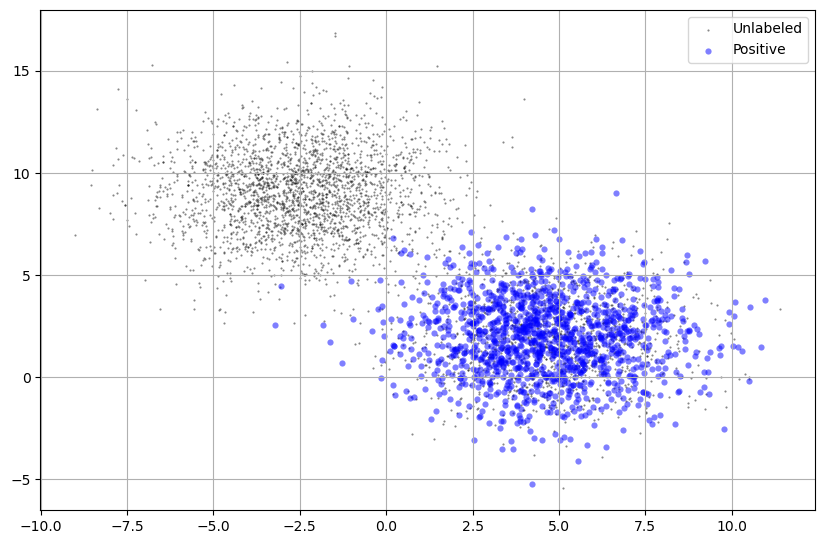

In [52]:
N = 5000
known_labels_ratio = 0.5
X, y = make_blobs(n_samples=N, centers=2,
                  n_features=2, shuffle=True,
                  cluster_std=2,
                  #cluster_std=5, 
                  random_state=42)

rp = np.random.permutation(int(N/2))

data_P = X[y == 1][rp[:int(len(rp) * known_labels_ratio)]]

data_U = np.concatenate(
    (X[y ==1 ][rp[int(len(rp) * known_labels_ratio):]], X[y == 0]),
    axis=0)
print(f'labeled samples: {data_P.shape[0]}')

plt.figure(figsize=(10, 6.5))
plt.scatter(data_U[:,0], data_U[:, 1], c='k', marker = '.', lw =1, s=1, alpha = 0.5, label = 'Unlabeled')
plt.scatter(data_P[:,0], data_P[:, 1], c='b', marker = 'o', lw=0, s=20, alpha=0.5, label = 'Positive')
plt.grid()
plt.legend();

lets train 1000 tress
oob forecast

In [53]:
NP = data_P.shape[0]
NU = data_U.shape[0]

num_trees = 1000
train_label = np.zeros(shape=(NP+NP,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))

for i in range(num_trees):
    #Bootstrap resample:
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=NP)
    #Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U[bootstrap_sample,:]), axis=0)
    #train model
    
    model = DecisionTreeClassifier(class_weight = 'balanced')
    model.fit(data_bootstrap, train_label)
    
    #Index of the out of the bag(oob) samples 
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    
    #Trsnsductive learnubg of oob samples
    
    f_oob[idx_oob] += model.predict_proba(data_U[idx_oob])
    n_oob[idx_oob] +=1
    
predict_proba = f_oob[:, 1] /n_oob

In [54]:
#lets count Precision. REcall and Threshold

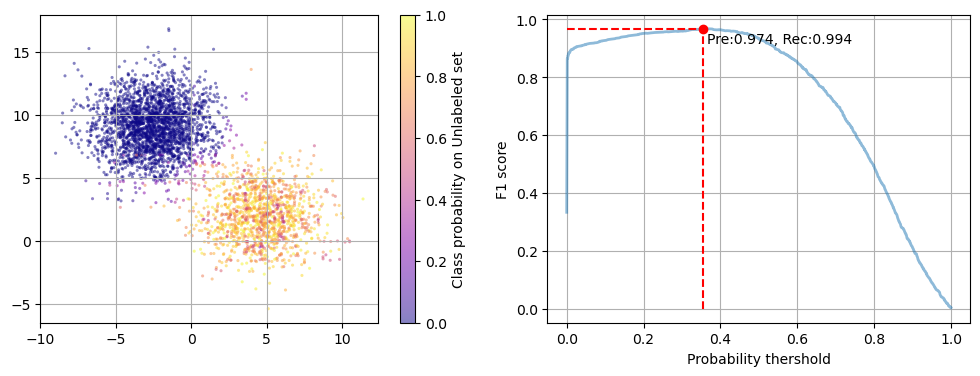

In [56]:
#Plot the class probabilities for the unlabeled samples

fig = plt.figure(figsize=(12,4))
ax1 =  fig.add_subplot(1,2,1)
sp =  ax1.scatter(data_U[:,0], data_U[:,1], c= predict_proba,
                  lw=0, s=5, alpha=0.5, cmap = plt.cm.plasma, label = 'unlabeled')
plt.grid()
plt.colorbar(sp, label = 'Class probability on Unlabeled set')

true_labels = np.zeros(shape=(data_U.shape[0]))
true_labels[:int(len(rp) * (1.0 - known_labels_ratio))] = 1.0

precision, recall, th = precision_recall_curve(true_labels, predict_proba)
ax2 = fig.add_subplot(1,2,2)
f1s = precision[:-1] * recall[:-1]
ax2.plot(th, f1s, lw =2, alpha= 0.5)

best_th = np.argmax(f1s)
ax2.plot(th[best_th], f1s[best_th], c='r', marker = 'o')
ax2.plot([th[best_th], th[best_th]], [0.0, f1s[best_th] ], 'r--')
ax2.plot([0.0, th[best_th]], [f1s[best_th], f1s[best_th] ], 'r--')
ax2.annotate(f'Pre:{precision[best_th]:.3f}, Rec:{recall[best_th]:.3f}',
             xy=(th[best_th] +0.01, f1s[best_th]-0.05))
ax2.set_ylabel('F1 score')
ax2.set_xlabel('Probability thershold')
plt.grid()

Example2

In [60]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt


In [61]:
items = pd.read_csv('items.csv')

In [63]:
print(f"Num unique items: {items.shape[0]}\nNum unique categories: {len(items['item_type'].unique())}")

items.head(3)

Num unique items: 10237
Num unique categories: 10


,Name,item_category,item_brand,item_weight,item_type
0,зубная паста лакалют актив 75мл,"Красота, гигиена, бытовая химия",splat,75мл,зубная паста
1,зубная паста лакалют сенситив 75мл,"Красота, гигиена, бытовая химия",splat,75мл,зубная паста
2,зубная паста лесной бальзам ромашка и облепиха...,"Красота, гигиена, бытовая химия",лесной бальзам,NaN,зубная паста


In [72]:
purchases = pd.read_csv('purchases.csv')
print(f"num unique users: {len(purchases['user_id'].unique())}")
purchases.columns = ['user_id', 'Name']
purchases.head(3)


num unique users: 32000


,user_id,Name
0,ed6b1aaf-21df-5b75-9b7f-ed67926cd17c,"шоколад ""alpen gold"" белый с миндалем и кокосо..."
1,ba82ad84-3a19-5a91-8e1e-7fd87628afb4,пюре тема говядина с гречкой с 8 месяцев
2,74a2856d-f0ec-59a6-89f3-1f80b294e852,колбаса микоян сервелат кремлевский варено-коп...


We need to promote tea with discount to 5k users okt of 32k

In [73]:
purchases = pd.merge(purchases, items)
purchases.head(3)

,user_id,Name,item_category,item_brand,item_weight,item_type
0,ed6b1aaf-21df-5b75-9b7f-ed67926cd17c,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад
1,b4a10859-3f8c-5dc1-8d5d-5977f9aa8bde,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад
2,464053f2-ead4-500e-8486-9d5d66c1bbd7,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад


In [74]:
len(purchases[purchases['item_type']=='чай']['user_id'].unique())

1360

In [87]:
purchases['y'] = purchases['item_type'].apply(lambda x: 1 if x=='чай' else 0, 1)
purchases.head()

,user_id,Name,item_category,item_brand,item_weight,item_type,y
0,ed6b1aaf-21df-5b75-9b7f-ed67926cd17c,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад,0
1,b4a10859-3f8c-5dc1-8d5d-5977f9aa8bde,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад,0
2,464053f2-ead4-500e-8486-9d5d66c1bbd7,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад,0
3,baf7d53b-3170-5984-b05c-c5d2b8788d57,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад,0
4,ef6beb0e-a09e-5372-aa91-eb467f117aa8,"шоколад ""alpen gold"" белый с миндалем и кокосо...","Хлеб, сладости, снеки",alpen gold,90г,шоколад,0


In [88]:
X = purchases.groupby(['user_id']).agg({'Name': lambda x: list(x), 
                                    'y': lambda x: max(x)})
X['user_id'] = [i for i in X.index.values]
X.columns = ['last_purchases', 'y', 'user_id']
X = X[['user_id', 'last_purchases', 'y']]
X.index = range(len(X))
X.head(3)

,user_id,last_purchases,y
0,00002f01-66e4-5ab8-8d1a-1562a4ddd418,[зубная паста splat stress off антистресс 75мл...,0
1,0000fed8-b063-51ef-8ca4-c42c5bd022ad,[шоколад schogetten black & white молочный с к...,0
2,0004cfe8-bcb2-5a2c-904b-643e0469cbe3,"[шоколад воздушный темный 85г, сыр белебеевски...",0


In [89]:
X['y'].value_counts()

0    30640
1     1360
Name: y, dtype: int64

In [90]:
X['last_purchases'] = X['last_purchases'].apply(lambda x: " ".join(x), 1)
X.head()

,user_id,last_purchases,y
0,00002f01-66e4-5ab8-8d1a-1562a4ddd418,зубная паста splat stress off антистресс 75мл ...,0
1,0000fed8-b063-51ef-8ca4-c42c5bd022ad,шоколад schogetten black & white молочный с ку...,0
2,0004cfe8-bcb2-5a2c-904b-643e0469cbe3,шоколад воздушный темный 85г сыр белебеевский ...,0
3,000b8172-b96d-5c99-a418-fe1ca156bee1,шампунь pantene pro-v интенсивное восстановлен...,0
4,000bf80e-219c-53b7-a000-6c3474c2bd14,шоколад schogetten black & white молочный с ку...,0


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, X['y'], random_state=0)

In [92]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

pipeline = Pipeline([('last_purchases_selector', FeatureSelector(column='last_purchases')), 
                     ('last_purchases_tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression())])

In [93]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('last_purchases_selector',
                 FeatureSelector(column='last_purchases')),
                ('last_purchases_tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [94]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00987465, 0.00454258, 0.00221269, 0.02663074, 0.00402058,
       0.02508175, 0.00269904, 0.11747235, 0.01075453, 0.0036021 ])

In [95]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289859, F-Score=0.973, Precision=0.980, Recall=0.966


In [96]:
X['y_pred'] = pipeline.predict_proba(X)[:, 1]
X = X.sort_values('y_pred', ascending=False)
X.head(3)

,user_id,last_purchases,y,y_pred
1675,0d2f872b-6a49-5e95-9f2b-3ec9f9365dc6,"чай dammann зеленый с жасмином, 25пак*2г корм ...",1,0.999988
19586,9c753d40-22ef-5491-b907-ff76f03d2044,шоколад chokodelika темный с грецким орехом 16...,1,0.999952
15436,7c615620-53bf-59ce-8186-8d4f88ceca73,"шоколад lindt creation тёмный с мятой 0,15кг н...",1,0.999933


In [97]:
X.tail(3)

,user_id,last_purchases,y,y_pred
18431,936bb290-9ce5-5bde-a81a-4677774dccd9,зубная паста splat kids фруктовое мороженое 2-...,0,0.000256
5344,2b8e5020-1814-56c2-b466-7f26760b945f,колбаса микоян сервелат кремлевский варено-коп...,0,0.000256
19909,9efb8eb7-b704-5129-ac36-cd9fc7cb488b,напиток mirinda апельсин б/алк газ 2л пэт колб...,0,0.000189


In [98]:
selected_users = X.iloc[:5000]['user_id'].values

In [99]:
purchases[purchases['user_id'].isin(selected_users)]['item_type'].value_counts(normalize=True)

кофе            0.22604
шоколад         0.20240
напиток         0.13028
шампунь         0.12380
чай             0.06292
сыр             0.06284
зубная паста    0.05548
колбаса         0.05180
пюре            0.04372
корм            0.04072
Name: item_type, dtype: float64

In [100]:
purchases[~purchases['user_id'].isin(selected_users)]['item_type'].value_counts(normalize=True)

колбаса         0.224785
зубная паста    0.178756
корм            0.125830
шоколад         0.105156
шампунь         0.097193
напиток         0.096600
сыр             0.065822
кофе            0.054111
пюре            0.051748
Name: item_type, dtype: float64

In [101]:
feature_names = [i for i in pipeline.named_steps["last_purchases_tfidf"].get_feature_names()]
feature_weights = [i for i in pipeline.named_steps["clf"].coef_[0]]
weights = pd.DataFrame({'feature_name': feature_names,
              'feature_weight': feature_weights}).sort_values('feature_weight', ascending=False)
#топ 100 слов
weights['feature_name'].iloc[:100].values

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['чай', 'черный', '25пак', 'листовой', 'зеленый', '2г', 'fuzetea',
       'greenfield', '20', 'байховый', '20пак', 'ahmad', '8г',
       'пакетиков', '100пак', '25', 'крупнолистовой', 'tess', 'curtis',
       'травяной', 'richard', 'майский', '5г', 'ароматом', 'grey',
       'hyleys', 'dammann', 'принцесса', 'basilur', 'the', 'цейлонский',
       'ceylon', 'шиповник', 'maitre', 'milford', 'азерчай', '20п',
       'nadin', 'китайский', 'newby', 'de', 'пирамидках', 'mlesna', '50г',
       'пирамидок', 'жасмином', 'sonnentor', 'earl', 'чабрецом', 'нури',
       'vитамин', 'twinings', 'грей', 'green', 'гармония', '200г',
       'витацентр', 'английский', '20пир', 'айдиго', 'жень', 'японски',
       'тянь', 'цейлон', 'индийский', 'ромашка', 'природы', '75л',
       'grace', 'akbar', 'чёрный', 'ява', 'collection', 'добавками',
       'иван', 'улун', 'riston', 'холодный', '25шт', 'вкусов',
       'среднелистовой', 'breakfast', '0г', 'юдзу', 'дракон', 'мелиссой',
       'пакетированный',